# Inheritance: For Better or for Worse 
- In this chapter we’ll focus on four characteristics of Python: 
    - The `super()` function 
    - The pitfalls of subclassing from built-in types 
    - Multiple inheritance and method resolution order 
    - Mixin classes
- Multiple inheritance is the ability of a class to have more than one base clas
- In 2021, there is a backlash against overuse of inheritance due to the tight coupling of superclasses and subclasses, leading to unexpected and far-reaching effects in other parts of the program. This makes systems brittle and hard to understand
- However, we have to 
    - **maintain existing systems** designed with complex class hierarchies 
    - or **use frameworks** that force us to use inheritance—even multiple inheritance sometimes.




## The `super()` Function 
- Consistent use the of the `super()` built-in function is **essential for maintainable object-oriented Python programs**.

In [ ]:
# When a subclass overrides a method of a superclass, the overriding method usually 
# needs to call the corresponding method of the superclass.

class LastUpdatedOrderedDict(OrderedDict): 
    """Store items in the order they were last updated""" 
    
    def __setitem__(self, key, value): 
        super().__setitem__(key, value) #to call __setitem__ method on the superclass
        self.move_to_end(key)           #to ensure the updated key is in the last position.

- Invoking an overridden `__init__` method is particularly important to allow superclasses to do their part in initializing the instance.

In [ ]:


def __init__(self, a, b) : 
    super().__init__(a, b) 
    ... # more initialization code

- You may have seen code that doesn’t use `super()`, but instead calls the method directly on the superclass, like this: 

In [ ]:
class NotRecommended(OrderedDict): 
    """This is a counter example!""" 
    
    def __setitem__(self, key, value): 
        OrderedDict.__setitem__(self, key, value) 
        self.move_to_end(key)

- This alternative works in this particular case, but is not recommended for two reasons. 
    - First, it hardcodes the base class. it can lead to bugs if the base class is changed in the future. 
    - The second reason is that super implements logic to handle class hierarchies with multiple inheritance. 

- To conclude this refresher about super, it is useful to review how we had to call it in Python 2:

In [ ]:
class LastUpdatedOrderedDict(OrderedDict): 
    """This code works in Python 2 and Python 3""" 
    
    def __setitem__(self, key, value): 
        super(LastUpdatedOrderedDict, self).__setitem__(key, value) 
        self.move_to_end(key)

- Both arguments of super are now optional. 
- The Python 3 bytecode compiler automatically provides them by inspecting the surrounding context when super() is  invoked in a method. 
- The arguments are:
    - `type` : 
        - The start of the search path for the superclass implementing the desired method. 
        - By default, it is the class that owns the method where the super() call appears. 
    - `object_or_type`: 
        - The object (for instance method calls) or class (for class method calls) to be the  receiver of the method call. 
        - By default, it is self if the super() call happens in an instance method.

- Whether you or the compiler provides those arguments, the `super()` call returns a dynamic proxy object that **finds a method (such as __setitem__ in the example) in a superclass of the `type` parameter, and binds it to the `object_or_type`**. 
- so that we don’t need to pass the receiver (`self`) explicitly when invoking the method. 
- In Python 3, you can still explicitly provide the first and second arguments to `super()`. But they are needed only in special cases, such as:
    - skipping over part of the **MRO** for testing or debugging, 
    - or for working around undesired behavior in a superclass.

## Subclassing Built-In Types Is Tricky

- It was not possible to subclass built-in types such as `list` or `dict` in the earliest versions of Python. 
- Since Python 2.2, it’s possible, but there is a major caveat: 
    - the code of the **built-ins (written in C) usually does not call methods overridden by user-defined 
classes**.

- **Example 14-1** illustrates the problem. Our `__setitem__` override is ignored by the `__init__` and `__update__` methods of the built-in dict.

In [5]:
# Example 14-1

class DoppelDict(dict): 
    def __setitem__(self, key, value): 
        super().__setitem__(key, [value] * 2)   #DoppelDict.__setitem__ duplicates values when storing .It works by delegating to the superclass. 
        

In [6]:
# The __init__ method inherited from dict clearly ignored that __setitem__ was overridden:
# the value of 'one' is not duplicated.
dd = DoppelDict(one=1)
dd

{'one': 1}

In [7]:
#The [] operator calls our __setitem__ and works as expected: 'two' maps to the duplicated value [2, 2]. 
dd['two'] = 2
dd

{'one': 1, 'two': [2, 2]}

In [8]:
#The update method from dict does not use our version of __setitem__ either: the value of 'three' was not duplicated.
dd.update(three=3)
dd

{'one': 1, 'two': [2, 2], 'three': 3}

- This built-in behavior is a violation of a basic rule of OOP: 
    - the search for methods should always start from the class of the receiver (`self`), even when the call happens inside a method implemented in a superclass. 
    - This is what is called **late binding**:
        - in any call of the form `x.method()`, **the exact method to be called must be determined at runtime**, based on the class of the receiver `x`.

- The problem is not limited to calls within an instance, but **also happens with overridden methods of other classes 
that should be called by the built-in methods**.

- **Example 14-2.** The `__getitem__` of `AnswerDict`is bypassed by `dict.update`.

In [1]:
# Example 14-2.
class AnswerDict(dict): 
    def __getitem__(self, key): 
        return 42  # always returns 42, no matter what the key.

In [2]:
ad = AnswerDict(a='foo') # ad is an AnswerDict loaded with the key-value pair ('a', 'foo').
ad['a']                  # ad['a'] returns 42, as expected. 

42

In [3]:
d = {} 
d.update(ad) # d is an instance of plain dict, which we update with ad. 
d['a']       # The dict.update method ignored our AnswerDict.__getitem__.

'foo'

In [4]:
d

{'a': 'foo'}

- Subclassing built-in types like `dict` or `list` or `str` directly is error prone because **the built-in methods mostly ignore user-defined overrides**. 
- Instead of subclassing the built-ins, **derive your classes from the `collections` module using `UserDict`, `UserList`, and `UserString`**, which are designed to be easily extended.

- **Example 14-3**. `DoppelDict2` and `AnswerDict2`work as expected because they extend `UserDict`and not `dict`.

In [5]:
#Example 14-3
import collections 

class DoppelDict2(collections.UserDict): 
    def __setitem__(self, key, value): 
        super().__setitem__(key, [value] * 2)

In [6]:
dd = DoppelDict2(one=1)
dd

{'one': [1, 1]}

In [7]:
dd['two'] = 2 
dd

{'one': [1, 1], 'two': [2, 2]}

In [8]:
dd.update(three=3)
dd

{'one': [1, 1], 'two': [2, 2], 'three': [3, 3]}

In [9]:
class AnswerDict2(collections.UserDict): 
    def __getitem__(self, key): 
        return 42

In [10]:
ad = AnswerDict2(a='foo') 
ad['a'] 

42

In [11]:
d = {} 
d.update(ad) 
d['a']

42

In [12]:
d

{'a': 42}

- This issue applies only to method delegation within the C language code of the built-in types, and only affects classes derived directly from those types. 
- If you subclass a base class coded in Python, such as `UserDict` or `MutableMapping`, you will not be troubled by this.

## Multiple Inheritance and Method Resolution Order 

- **diamond problem**:
    - potential naming conflicts when superclasses implement a method by the same name.

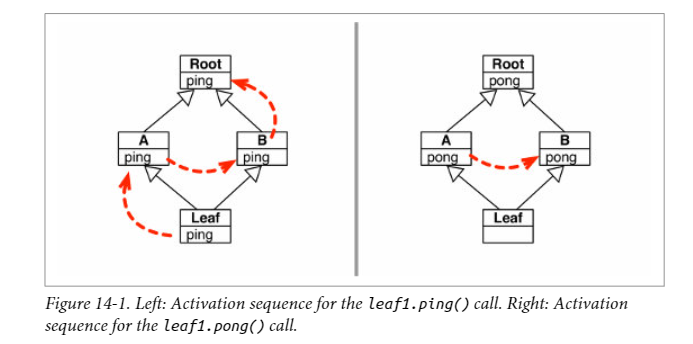

- **Example 14-4**. diamond.py: classes `Leaf`, `A`, `B`, `Root` form the graph in Figure 14-1.

In [2]:
# Example 14-4. diamond.py
class Root:  # Root provides ping, pong, and __repr__ to make the output easier to read.
    
    def ping(self): 
        print(f'{self}.ping() in Root') 
        
    def pong(self): 
        print(f'{self}.pong() in Root') 
        
    def __repr__(self):
        cls_name = type(self).__name__ 
        return f'<instance of {cls_name}>' 
    
    
class A(Root): # The ping and pong methods in class A both call super().
        
    def ping(self): 
        print(f'{self}.ping() in A') 
        super().ping() 
        
    def pong(self): 
        print(f'{self}.pong() in A') 
        super().pong() 
    
class B(Root): # Only the ping method in class B calls super().
        
    def ping(self): 
        print(f'{self}.ping() in B') 
        super().ping() 

    def pong(self): 
        print(f'{self}.pong() in B') 

class Leaf(A, B): # Class Leaf implements only ping, and it calls super().
    def ping(self): 
        print(f'{self}.ping() in Leaf') 
        super().ping() 
        
class Leaf2(B, A):
    def ping(self): 
        print(f'{self}.ping() in Leaf') 
        super().ping() 

In [29]:
leaf1 = Leaf() 
leaf1.ping()  
print(Leaf.__mro__)
leaf2 = Leaf2() 
leaf2.ping()  
print(Leaf2.__mro__)

# Calling leaf1.ping() activates the ping methods in Leaf, A, B, and Root, 
# because the ping methods in the first three classes call super().ping(). 

<instance of Leaf>.ping() in Leaf
<instance of Leaf>.ping() in A
<instance of Leaf>.ping() in B
<instance of Leaf>.ping() in Root
(<class '__main__.Leaf'>, <class '__main__.A'>, <class '__main__.B'>, <class '__main__.Root'>, <class 'object'>)
<instance of Leaf2>.ping() in Leaf
<instance of Leaf2>.ping() in B
<instance of Leaf2>.ping() in A
<instance of Leaf2>.ping() in Root
(<class '__main__.Leaf2'>, <class '__main__.B'>, <class '__main__.A'>, <class '__main__.Root'>, <class 'object'>)


In [30]:
leaf1.pong() 
print()
leaf2.pong() 
#Calling leaf1.pong() activates pong in A via inheritance, 
# which then calls super.pong(), activating B.pong.

<instance of Leaf>.pong() in A
<instance of Leaf>.pong() in B

<instance of Leaf2>.pong() in B


- The activation sequences are determined by two factors: 
    - The method resolution order of the `Leaf` class. 
    - The use of `super()` in each method.

In [16]:
Leaf.__mro__ 

(__main__.Leaf, __main__.A, __main__.B, __main__.Root, object)

- The MRO only determines the activation order, but whether a particular method will be activated in each of the classes depends on whether each implementation calls `super()` or not.
- The MRO takes into account not only the inheritance graph but also the order in which superclasses are listed in a subclass declaration.

- When a method calls `super()`, it is a **cooperative method**. 
- In order to work, multiple inheritance in Python requires the active cooperation of the methods involved. **In the `B` class, `ping` cooperates, but `pong` does not**.
- If `B.pong` is activated before `A.pong`, it drops the ball. 
- It is recommended that every method `m`of a nonroot class should call `super().m()`.

- Python is a dynamic language, so the interaction of `super()` with the MRO is also dynamic.

In [21]:
# Example 14-6. diamond2.py: classes to demonstrate the dynamic nature of super()
#from diamond import A 

class U():   # Class U is unrelated to A or Root from the diamond module.
    def ping(self): 
        print(f'{self}.ping() in U') 
        super().ping()  # What does super().ping() do? Answer: it depends.

class LeafUA(U, A): 
    def ping(self): 
        print(f'{self}.ping() in LeafUA') 
        super().ping()

In [22]:
#The 'super' object returned by super() has no attribute 'ping' because the MRO 
#of U has two classes: U and object, and the latter has no attribute named 'ping'.
u = U() 
print(U.__mro__)
u.ping()

(<class '__main__.U'>, <class 'object'>)
<__main__.U object at 0x000002A8402C13D0>.ping() in U


AttributeError: 'super' object has no attribute 'ping'

In [23]:
leaf2 = LeafUA() 
print(LeafUA.__mro__)
leaf2.ping() 

(<class '__main__.LeafUA'>, <class '__main__.U'>, <class '__main__.A'>, <class '__main__.Root'>, <class 'object'>)
<instance of LeafUA>.ping() in LeafUA
<instance of LeafUA>.ping() in U
<instance of LeafUA>.ping() in A
<instance of LeafUA>.ping() in Root


In [6]:
LeafUA.__mro__

(__main__.LeafUA, __main__.U, diamond.A, diamond.Root, object)

- If instead the bases were `(A, U)`, then `leaf2.ping()` would never reach `U.ping`, because the `super().ping()` 
in `A.ping` would activate `Root.ping`, and that method does not call `super()`.

In [24]:
#from diamond import A 

class U():   # Class U is unrelated to A or Root from the diamond module.
    def ping(self): 
        print(f'{self}.ping() in U') 
        super().ping()  # What does super().ping() do? Answer: it depends.

class LeafUA(A, U): 
    def ping(self): 
        print(f'{self}.ping() in LeafUA') 
        super().ping()
leaf2 = LeafUA() 
print(LeafUA.__mro__)
leaf2.ping() 

(<class '__main__.LeafUA'>, <class '__main__.A'>, <class '__main__.Root'>, <class '__main__.U'>, <class 'object'>)
<instance of LeafUA>.ping() in LeafUA
<instance of LeafUA>.ping() in A
<instance of LeafUA>.ping() in Root


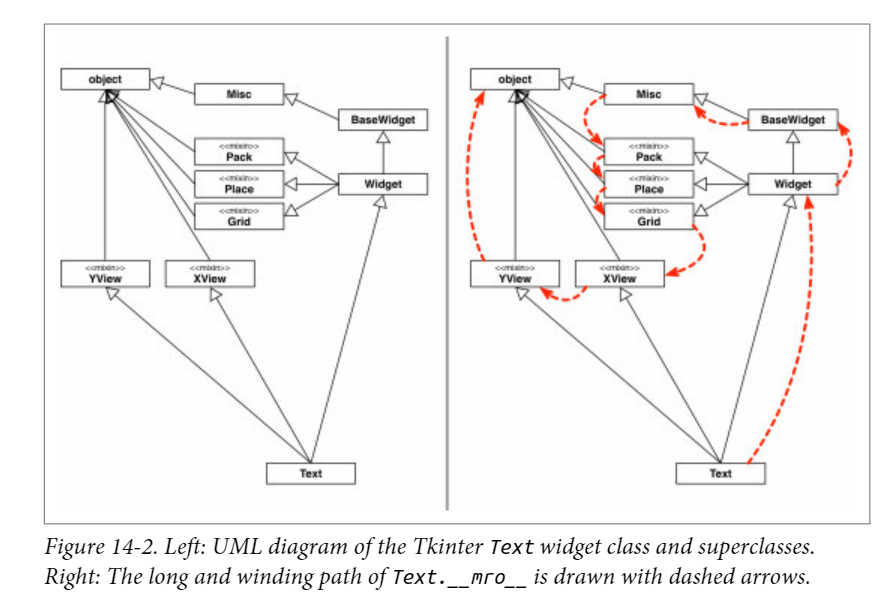

In [26]:
# Example 14-7. MRO of tkinter.Text 
def print_mro(cls): 
    print(', '.join(f"{e}:{c.__name__}"for e,c in enumerate(cls.__mro__,1))) 
import tkinter 
print_mro(tkinter.Text) 

1:Text, 2:Widget, 3:BaseWidget, 4:Misc, 5:Pack, 6:Place, 7:Grid, 8:XView, 9:YView, 10:object


## Mixin Classes 

- A mixin class is designed **to be subclassed together with at least one other class in a multiple inheritance arrangement**. 
- A mixin is **not supposed to be the only base class of a concrete class**, because it does not provide all the functionality for a concrete object.
- Only adds or customizes the behavior of child or sibling classes.

### Case-Insensitive Mappings 

In [14]:
#Example 14-8. uppermixin.py: UpperCaseMixin supports case-insensitive mappings 

import collections 

def _upper(key): 
    try: 
        return key.upper() 
    except AttributeError: 
        return key

class UpperCaseMixin: # The mixin implements four essential methods of mappings,
    
    def __setitem__(self, key, item): 
        super().__setitem__(_upper(key), item)

    def __getitem__(self, key): 
        return super().__getitem__(_upper(key)) 

    def get(self, key, default=None): 
        return super().get(_upper(key), default) 

    def __contains__(self, key): 
        return super().__contains__(_upper(key))

- Mixins **must appear first** in the tuple of base classes in a class declaration.

In [18]:
# Example 14-9. uppermixin.py: two classes that use UpperCaseMixin 

#  UpperCaseMixin must be the first base class, otherwise the methods from UserDict would be called instead.
class UpperDict(UpperCaseMixin, collections.UserDict): 
    pass 

class Empty:
    pass

class Wrong(UpperCaseMixin,Empty):
    pass
# Instead of pass, it’s better to provide a docstring to satisfy the need for a body in the class statement syntax.
class UpperCounter(UpperCaseMixin, collections.Counter): 
    """Specialized 'Counter' that uppercases string keys""" 

print(UpperDict.__mro__)
print(Wrong.__mro__)
#w = Wrong()
#w['a'] = '1'

(<class '__main__.UpperDict'>, <class '__main__.UpperCaseMixin'>, <class 'collections.UserDict'>, <class 'collections.abc.MutableMapping'>, <class 'collections.abc.Mapping'>, <class 'collections.abc.Collection'>, <class 'collections.abc.Sized'>, <class 'collections.abc.Iterable'>, <class 'collections.abc.Container'>, <class 'object'>)
(<class '__main__.Wrong'>, <class '__main__.UpperCaseMixin'>, <class '__main__.Empty'>, <class 'object'>)


In [11]:
d = UpperDict([('a', 'letter A'), (2, 'digit two')]) 
list(d.keys())

['A', 2]

In [12]:
d['b'] = 'letter B' 
'b' in d

True

In [13]:
d['a'], d.get('B') 

('letter A', 'letter B')

In [14]:
list(d.keys()) 

['A', 2, 'B']

In [15]:
c = UpperCounter('BaNanA') 
c.most_common()

[('A', 3), ('N', 2), ('B', 1)]

- We had to carefully study the code of `UserDict` and `Counter` to make `UpperCaseMixin` work with them.
- Author: For example, my first version of `UpperCaseMixin` did not provide the `get` method. That version worked with `UserDict` but not with `Counter`:
    - The `UserDict` class inherits `get` from `collections.abc.Mapping`, and that `get` calls `__getitem__`, which I  implemented. 
    - But keys were not uppercased when an `UpperCounter` was loaded upon `__init__`. 
    - That happened because `Counter.__init__` uses `Counter.update`, which in turn relies on the `get` method inherited from `dict`. However, the `get` method in the `dict` class does not call `__getitem__`. 

## Multiple Inheritance in the Real World 
### ABCs Are Mixins Too

- In the Python standard library, the most visible use of multiple inheritance is the `collections.abc` package.
- Python’s official documentation of `collections.abc` uses the term *mixin method* for the concrete methods implemented in many of the collection ABCs. The ABCs that provide mixin methods play two roles: 
    - they are interface definitions 
    - and also mixin classes. 

### ThreadingMixIn and ForkingMixIn

- The *http.server* package provides `HTTPServer` and `ThreadingHTTPServer` classes.

- class `http.server.ThreadingHTTPServer(server_address, RequestHandlerClass)`: 
    - is identical to `HTTPServer` **but uses threads to handle requests by using the `ThreadingMixIn`**. This is useful to handle web browsers pre-opening sockets, on which `HTTPServer` would wait indefinitely.

In [ ]:
class ThreadingHTTPServer(socketserver.ThreadingMixIn, HTTPServer): 
    daemon_threads = True 

In [ ]:
#Example 14-10. Part of Lib/socketserver.py in Python 3.10 

class ThreadingMixIn: 
    """Mixin class to handle each request in a new thread.""" 
    # 8 lines omitted in book listing 
    
    def process_request_thread(self, request, client_address): #does not call super() because it is a new method, not an override. 
        # 6 lines omitted in book listing 

    def process_request(self, request, client_address): # It does not call super(). 
        # 8 lines omitted in book listing 

    def server_close(self):       # server_close calls super().server_close() to stop taking requests, then waits  
        super().server_close()    # for the threads started by process_request to finish their jobs.
        self._threads.join()

### Django Generic Views Mixins

- In Django, a view is a callable object that takes a request argument—an object representing an HTTP request—and returns an object representing an HTTP response. 
- **The different responses are what interests us in this discussion.** 
- Originally, Django provided a set of functions, called generic views, that implemented some common use cases.
- However, the original generic views were functions, so they were not extensible.
- The concept of class-based views was introduced in Django 1.3, along with a set of generic view classes organized as base classes, mixins, and ready-to-use concrete classes. 
- In Django 3.2, the base classes and mixins are in the base module of the ‍‍`django.views.generic` package. 

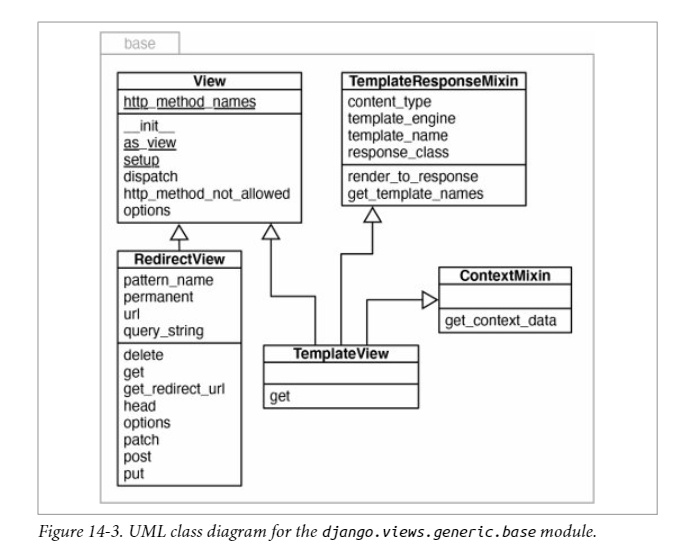

- `TemplateResponseMixin` :
    - provides functionality that is of interest only to views that need to use a template.
    - A RedirectView, for example, has no content body, so it has no need of a template and it does not inherit from this mixin.
    - provides behaviors to `TemplateView` and other template-rendering views, such as `ListView`, `DetailView`, etc., defined in the `django.views.generic` subpackages. 

- Figure 14-4 depicts the `django.views.generic.list` module and part of the `base`module.

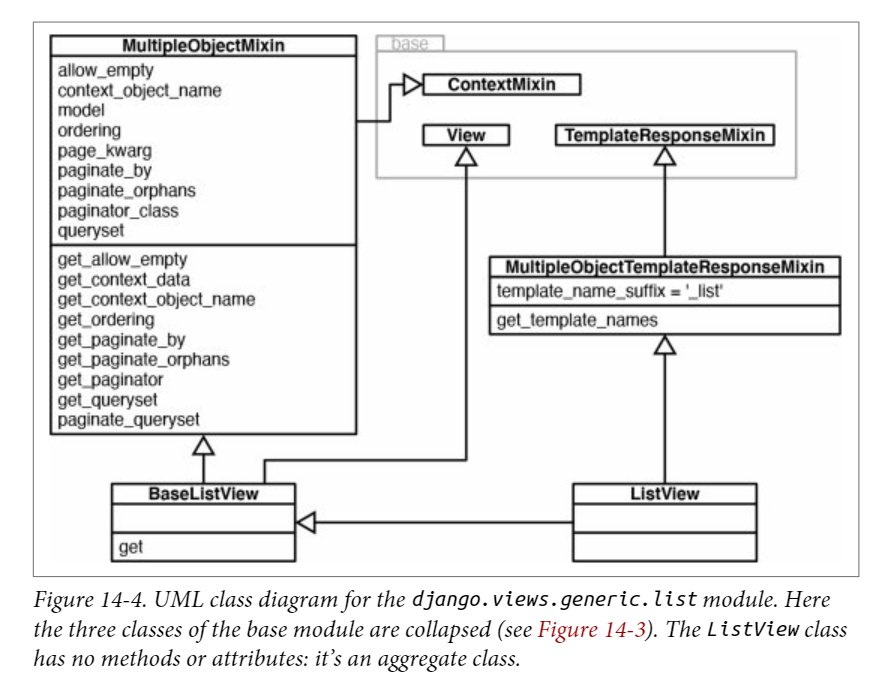

- For Django users, the most important class in Figure 14-4 is `ListView`, which is an **aggregate class**, with no code at all (its body is just a docstring).
    - When instantiated, a `ListView` has an `object_list` instance attribute through which the template can iterate to show the page contents, usually the result of a database query returning multiple objects. 
    - All the functionality related to generating this iterable of objects comes from the `MultipleObjectMixin`.

- Suppose you want to create a view that will not render a template, but will produce a list of objects in JSON format. That’s why the `BaseListView` exists. 
    - It provides an easy-to-use extension point that brings together `View` and `MultipleObjectMixin` functionality, without the overhead of the template machinery. 

### Multiple Inheritance in Tkinter

- An extreme example of multiple inheritance in Python’s standard library is the `Tkinter GUI toolkit`. 

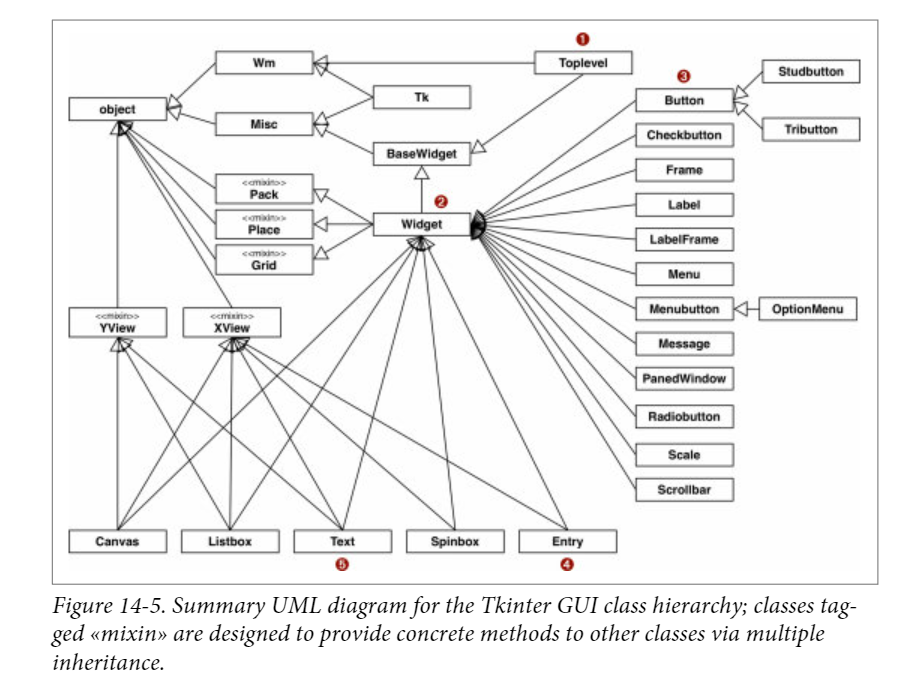

➊ Toplevel: The class of a top-level window in a Tkinter application. 

➋ Widget: The superclass of every visible object that can be placed on a window. 

➌ Button: A plain button widget. 

➍ Entry: A single-line editable text field. 

➎ Text: A multiline editable text field. 

In [27]:
#def print_mro(cls): 
#    print(', '.join(c.__name__ for c in cls.__mro__)) 
import tkinter 
print_mro(tkinter.Toplevel)
print_mro(tkinter.Widget) 
print_mro(tkinter.Button) 
print_mro(tkinter.Entry) 
print_mro(tkinter.Text)

1:Toplevel, 2:BaseWidget, 3:Misc, 4:Wm, 5:object
1:Widget, 2:BaseWidget, 3:Misc, 4:Pack, 5:Place, 6:Grid, 7:object
1:Button, 2:Widget, 3:BaseWidget, 4:Misc, 5:Pack, 6:Place, 7:Grid, 8:object
1:Entry, 2:Widget, 3:BaseWidget, 4:Misc, 5:Pack, 6:Place, 7:Grid, 8:XView, 9:object
1:Text, 2:Widget, 3:BaseWidget, 4:Misc, 5:Pack, 6:Place, 7:Grid, 8:XView, 9:YView, 10:object


- By current standards, the class hierarchy of `Tkinter` is very deep. 
- Few parts of the Python standard library have more than three or four levels of concrete classes, and the same can be said of the Java class library.
- In my experience, GUI toolkits are where inheritance is most useful.

## Coping with Inheritance

- What Alan Kay wrote in the epigraph remains true: 
    - there’s still no general theory about inheritance that can guide practicing programmers. 
    - What we have are rules of thumb, design patterns, “best practices,” clever acronyms, taboos, etc. 
    - Some of these provide useful guidelines, but none of them are universally accepted or always applicable. 

### Favor Object Composition over Class Inheritance

- Once you get comfortable with inheritance, it’s too easy to overuse it. 
    - Placing objects in a neat hierarchy appeals to our sense of order; programmers do it just for fun.
- Favoring composition leads to more flexible designs. 
    - For example, in the case of the `tkinter.Widget` class:
        - instead of inheriting the methods from all geometry managers, widget instances could hold a reference to a geometry manager, and invoke its methods. 
        - After all, **a `Widget` should not “be” a geometry manager**, but could use the services of one via delegation. 
        - Then you could add a new geometry manager without touching the widget class hierarchy and without worrying about name clashes.
        - Even with single inheritance, this principle enhances flexibility, because subclassing is a form of tight coupling, and tall inheritance trees tend to be brittle.
- Composition and delegation **can replace the use of mixins** to make behaviors available to different classes, **but cannot replace the use of interface inheritance** to define a hierarchy of types.

### Understand Why Inheritance Is Used in Each Case

- When dealing with multiple inheritance, it’s useful to keep straight the reasons why subclassing is done in each particular case. The main reasons are: 
    - Inheritance of interface creates a subtype, implying an “is-a” relationship. This is best done with ABCs.
    - Inheritance of implementation avoids code duplication by reuse. Mixins can help with this. 
- Inheritance for code reuse is an implementation detail, and it can often be replaced by composition and delegation
- Interface inheritance is the backbone of a framework. 
- Interface inheritance should use only ABCs as base classes, if possible. 

### Make Interfaces Explicit with ABCs 

- In modern Python, if a class is intended to define an interface, it should be an explicit ABC or a typing.Protocol subclass. 
- An ABC should subclass only abc.ABC or other ABCs. 
- Multiple inheritance of ABCs is not problematic. 

### Use Explicit Mixins for Code Reuse

- If a class is designed to provide method implementations for reuse by multiple unrelated subclasses, **without implying an “is-a” relationship**, it should be an explicit mixin class. 
- A mixin:
    - **does not define a new type**; it merely bundles methods for reuse. 
    - **should never be instantiated**, 
    - should provide **a single specific behavior**.
    - should avoid keeping any internal state; i.e., a mixin class should not have instance attributes. 
- concrete classes should not inherit only from a mixin.
-  It is highly recommended that they are named with a `Mixin` suffix. 


### Provide Aggregate Classes to Users

- Booch et al.: A class that is constructed primarily by inheriting from mixins and does not add its own structure or behavior is called an aggregate class. 

In [ ]:
# Django ListView class on the bottom right of Figure 14-4: 

class ListView(MultipleObjectTemplateResponseMixin, BaseListView): 
    """ 
    Render some list of objects, set by `self.model` or `self.queryset`. 
    `self.queryset` can actually be any iterable of items, not just a queryset.
    """

- The body of `ListView` is empty, but the class provides a useful service: 
    - **it brings together a mixin and a base class that should be used together**.
- Another example is `tkinter.Widget`, which has four base classes and no methods orattributes of its own—just a docstring. 
- Thanks to the `Widget` aggregate class, we can create new a widget with the required mixins, **without having to figure out in which order they should be declared to work as intended**.
- Aggregate classes don’t have to be completely empty, but they often are. 

### Subclass Only Classes Designed for Subclassing 

- Subclassing any complex class and **overriding its methods is error prone** because the superclass methods may ignore the subclass overrides in unexpected ways. 
- As much as possible:
    - **avoid overriding methods**, 
    - or at least restrain yourself to **subclassing classes which are designed to be easily extended**, 
    - and only **in the ways in which they were designed to be extended**.
- But how do we know whether or how a class was designed to be extended?
    - The first answer is documentation (docstrings or comments in code):
        - For example: Python’s `socketserver` package is described as “a framework for network servers.” 
        - Its `BaseServer` class is designed for subclassing, as the name suggests. 
        - More importantly, the documentation and the docstring in the source code of the class explicitly note which of its methods are intended to be over‐ ridden by subclasses.
    - In Python ≥ 3.8, a new way of making those design constraints explicit is provided by **PEP 591—Adding a final qualifier to typing**. 
        - The PEP introduces a `@final` decorator that can be applied to classes or individual methods, so that **IDEs or type checkers can report misguided attempts to subclass those classes or override those methods**.

### Avoid Subclassing from Concrete Classes

- Subclassing concrete classes is **more dangerous than subclassing ABCs and mixins**, 
    - because instances of concrete classes usually have internal state that can easily be corrupted when you override methods that depend on that state. 
    - Even if your methods cooperate by calling `super()`, and the internal state is held in private attributes using the `__x` syntax, 
    - there are still countless ways a method override can introduce bugs. 
- Scott Meyer: “all non-leaf classes should be abstract.” 
    - In other words, Meyer recommends that **only abstract classes should be subclassed**. 
- If you must use subclassing for code reuse, 
    - then the code intended for reuse should be in mixin methods of ABCs 
    - or in explicitly named mixin classes. 


### Tkinter: The Good, the Bad, and the Ugly 

- Most advice in the previous section is not followed by `Tkinter`
    - with the notable exception of “Provide Aggregate Classes to Users”.
    - composition would probably work better for integrating the geometry managers into `Widget`, as discussed in “Favor Object Composition over Class Inheritance”.
- The docstring of `tkinter.Widget` starts with the words “Internal class.” 
    - This suggests that `Widget` should probably be an ABC. 
    - Although `Widget` has no methods of its own, **it does define an interface.** 
        - Its message is: “You can count on every Tkinter widget providing basic widget methods (`__init__`, `destroy`, and dozens of Tk API functions), in addition to the methods of all three geometry managers.” 
    - We can agree that **this is not a great interface definition** (it’s just too broad), but it is an interface, and `Widget` “defines” it as the union of the interfaces of its superclasses.
- The `Tk` class, inherits from `Wm` and `Misc`:
    - neither of which are abstract or mixin. 
        - `Wm` is **not a proper mixin** because `TopLevel` subclasses only from it.
    - The name of the Misc class is—by itself—a very strong code smell. 
        - Misc has more than 100 methods, and all widgets inherit from it. 
        - Misc should be split into several specialized mixin classes, and not all widgets should inherit from every one of those mixins. 

## Soapbox

### Think about the Classes You Really Need 

- Alan Kay: [We] started to push on the inheritance idea as a way to let novices build on frameworks that could only be designed by experts. 
- The vast majority of programmers write applications, not frameworks. 
    - When we write applications, we normally don’t need to code class hierarchies. 
    - At most, we write classes that **subclass from ABCs or other classes provided by the framework**. 
- If, while working as an application developer, you find yourself building multilevel class hierarchies, it’s likely that one or more of the following applies: 
    - You are reinventing the wheel. Go look for a framework or library that provides components you can reuse in your application. 
    - You are using a badly designed framework. Go look for an alternative. 
    - You are overengineering. Remember the KISS principle. 
    - You became bored coding applications and decided to start a new framework. Congratulations and good luck! 

### Misbehaving Built-Ins: Bug or Feature?

- The built-in `dict`, `list`, and `str` types are essential building blocks of Python itself, 
so they must be fast.
- That’s why CPython adopted the shortcuts that **cause its built-in methods to misbehave by not cooperating with methods overridden by subclasses**. 
- A possible way out of this dilemma would be to **offer two implementations for each of those types***: 
    - one “internal,” optimized for use by the interpreter, 
    - and an external, easily extensible one.
        -  `UserDict`, `UserList`, and `UserString` are not as fast as the built-ins but are easily extensible.

## Lecturers

- Somayeh Pakdel: [Linkedin](https://www.linkedin.com/in/somayeh-pakdelmoez-901439176/)
- mosTafa Arshadi: [Linkedin](https://www.linkedin.com/in/mostafa-arshadi-6b1576223/)

Presentation Date: 05-01-2024
